<a href="https://colab.research.google.com/github/lucas-pinto/NUIN443/blob/main/problemSets/NUIN443_ps1_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROBLEM SET 1: REGRESSION #

Here we will review some of the key concepts from the regression class. <br>
We will first play with some toy data, using custom written algorithms to fit it with OLS, least mean squares, or ridge. <br>
We will then do logistic regression on some real behavioral data from the Pinto Lab. Have fun! <br>

In [2]:
# IMPORT SOME LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import stats # for z scoring
from sklearn.model_selection import RepeatedKFold # for cross val in problem 4
from sklearn.linear_model import LogisticRegression # for problem 4


%matplotlib widget
%matplotlib widget


In [4]:
# DOWNLOAD DATA
!wget -nc https://www.dropbox.com/scl/fi/u430bflj0wa8u40bip539/nuin443_ols_data.pickle?rlkey=x6gggiaxx3kwcn20d5lzkf2dj&dl=0
!wget -nc https://www.dropbox.com/scl/fi/khlt5gezj3cwqscmfg3u7/nuin443_ridge_data.pickle?rlkey=63tersdczwyln9brx0pm06rs2&dl=0
!wget -nc https://www.dropbox.com/scl/fi/0ohjs6xxlgfx3qumfzpvi/nuin443_towers_df.pickle?rlkey=5td9e8dl0zwy1qgdpb8i2cgqb&dl=0

## Problem 1: OLS ##

**1a**. Load the data. \\(X\\) is the predictor matrix and \\(y\\) is the response vector. <br>
**1b**. Is this a good candidate for OLS? Check that the correlation matrix \\(X^TX\\) is not singular.  <br>
**1c**. Write your own OLS function using linear algebra.  <br>
**1d**. Fit the data and print the weight vector, including the intercept term.  <br>
**1e**. Write functions to compute the coefficient of determination \\(R^2\\) and the squared correlation coefficient between data and prediction, \\(r^2\\).  <br>
**1f**. Use your functions to assess the goodness of fit using both metrics. How do they compare? What does that say about the data?  <br>

In [6]:
# 1a. Load data
filename    = '../data/nuin443_ols_data.pickle?rlkey=x6gggiaxx3kwcn20d5lzkf2dj'
with open(filename, 'rb') as handle:
    [X,y] = pickle.load(handle)

In [7]:
# 1b. Is X non-singular?
if np.linalg.det(np.dot(X.T, X)) != 0:
    print('X is singular')


X is singular


In [8]:
# 1c. Define your OLS function (fill this in)

def OLS(X,y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

def X_offset(X):
    offset = np.ones((X.shape[0], 1))
    return np.hstack((offset, X))


In [9]:
# 1d. Use your OLS function to find the weight vector w (remeber to add intercept!). Print result
X_ = X_offset(X)
w = OLS(X_, y)
y_hat = X_@w
print(w)



[10.13021508  1.62248651  0.24858747  5.31171729 -1.96749828]


In [10]:
# 1e. Define goodness-of-fit functions:

# Coefficient of determination (fill this in)
def fit_R2(y,y_hat):
    return 1 - ((np.sum((y-y_hat)**2)) / np.sum((y-np.average(y))**2))


# Squared correlation coefficient (fill this in)
def fit_r2(y,y_hat):
    return np.corrcoef(y, y_hat, rowvar=False)[0,1]**2

In [11]:
# 1f. Use the functions above to assess goodness of fit, print results 
print(fit_R2(y, y_hat))
print(fit_r2(y, y_hat))




0.9377085945326636
0.9377085945326635


In [ ]:
# 1f. How do they compare? What does that say about the data? (answer as code comment)

#They're the same... I think that the data is well-captured by OLS.  




## Problem 2: LMS ##
**2a**. Now write your own least mean squares algorithm (gradient descent) and <br>
**2b**. fit the same data. Print \\(w\\)

In [95]:
# 2a. Write your LMS algorithm.
# I'm suggesting some defaults for the hyperparameters
# (alpha is learning rate, tolerance is the amount of change in the gradient that makes you stop fitting)

def LMS(X,y,alpha=.001,maxiter=500,tolerance=1e-5):

    # initialize random weights
    w  = np.random.normal(size=np.size(X,axis=1))
    Xt = np.transpose(X)

    for i in range(maxiter):
        # compute gradient epsilon (fill this in)
        epsilon = (alpha*Xt) @ (X@w - y)

        if sum(abs(epsilon)) < tolerance:
            break
        else:
            w = w - epsilon
            # update weight (fill this in)

    return w

In [96]:
# 2b. Fit the same data with your LMS function and print w

Xs       = np.ones((500,5))
Xs[:,1:] = X
w        = LMS(Xs,y)
print(w)

[10.13021189  1.62248545  0.2485789   5.31171342 -1.96749253]


### Problem 3: ridge regression ##

**3a**. Load the new dataset \\(X_r\\) and \\(y_r\\). This time I made two of the variables correlated <br>
**3b**. Compute and plot the correlation matrix \\(X_r^TX_r\\) to figure out which are the correlated columns of \\(X_r\\) <br>
**3c**. Write your own function to do ridge regression using the analytical (linear algebra) solution <br>
**3d**. Use your function to fit the data, varying \\(\lambda\\) systematically between 0 and 100 <br>
**3e**. Plot the weight for each parameter as a function of \\(\lambda\\). What happens to weights for correlated vs. uncorrelated variables?  <br>
(note: you should use cross-validation irl to determine the best \\(\lambda\\) for your model)

In [12]:
# 3a. load data
filename    = '../data/nuin443_ridge_data.pickle?rlkey=63tersdczwyln9brx0pm06rs2'
with open(filename, 'rb') as handle:
    [Xr,yr] = pickle.load(handle)

[[  0.          -6.2261191   -3.36890558   0.57944763]
 [ -6.2261191    0.         470.49539308 -27.3917083 ]
 [ -3.36890558 470.49539308   0.         -26.90303935]
 [  0.57944763 -27.3917083  -26.90303935   0.        ]]


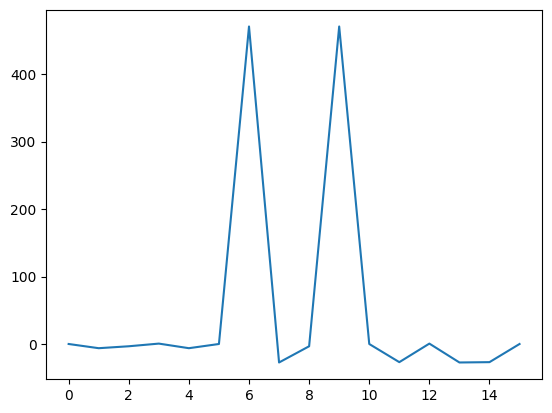

In [23]:
# 3b. Compute and plot X^TX to figure out which are the correlated variables
cov = Xr.T@Xr
# lets set diagonal to 0 for visualization pruposes
np.fill_diagonal(cov,0)
# lets flatten, plot, and sort
fig3, ax3 = plt.subplots()
ax3.plot(cov.flatten())
print(cov)
#looks like feature 1 and 2 (0-indexing) are correlated.

In [34]:
test = Xr_norm_offset
regtest = 2

array([[502.        ,   2.        ,   2.        ,   2.        ,
          2.        ],
       [  2.        , 502.        ,  -4.21663809,  -1.37569772,
          2.55874243],
       [  2.        ,  -4.21663809, 502.        , 486.64523935,
        -26.3355843 ],
       [  2.        ,  -1.37569772, 486.64523935, 502.        ,
        -25.77755928],
       [  2.        ,   2.55874243, -26.3355843 , -25.77755928,
        502.        ]])

In [36]:
# 3c. Write your ridge function (fill this in)

def ridge(X,y,lam):
    reg = lam*np.eye(X.shape[1])
    reg[0,0] = 0 #set intercept regterm to 0
    wr = np.linalg.inv(X.T@X+reg)@X.T@y
        

    return wr

In [37]:
# 3d. Fit the model with different values of lambda in the [0 100] interval
# Hint: remember to zscore/center X and y!

wr_all    = np.zeros((100,4))
lams      = np.linspace(0,100,100)
Xr_norm   = stats.zscore(Xr)
Xr_norm_offset = X_offset(Xr_norm)
ys        = yr-np.mean(yr)

for i in range(len(lams)):
    temp_w  = ridge(Xr_norm_offset, ys, lams[i])
    wr_all[i,:] = temp_w[1:]
    

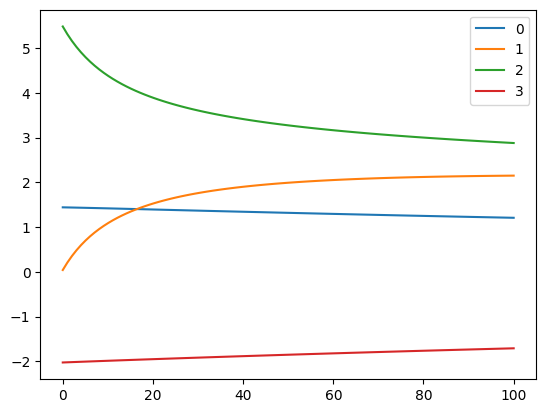

In [41]:
# 3d. Plot each weight as a function of lambda (on the same axis)

plt.figure()
plt.plot(lams,wr_all[:,0], label='0')
plt.plot(lams,wr_all[:,1], label='1')
plt.plot(lams,wr_all[:,2], label='2')
plt.plot(lams,wr_all[:,3], label='3')
plt.legend()

In [ ]:
# 3d. What happens to weights for correlated vs. uncorrelated variables? (answer as a comment)
#uncorrelated variable weights were essentially unchanged, while correlated variables converged to similar numbers.


## Problem 4: Bernoulli GLM (logistic regression) of behavioral choice ##

Now you get to play with some Pinto lab data! :-D <br>
This is choice data from the accumulating-towers task (Pinto*, Koay* et al, 2018, Front Behav Neurosci). Please refer to the paper if you're curious about the details. <br>
What you need to know for this problem is that mice navigate a virtual T maze, and experience pulsed visual stimuli (towers), which occur randomly (following Poisson statistics) on the right (R) and left (L) sides of the maze. This means that, on different trials, there are different number of R and L towers. The mice get rewarded for turning into the side arm corresponding to the side where they saw the most towers. Indeed, we see that their performance is clearly modulated by the amount of sensory evidence, which we will parametrize as \\( \Delta_{towers} = num. R \ – \ num. L\\). The thing that makes this problem fun, though, is that the ideal strategy is to just pay attention to the towers (since reward is deterministic), but mice often go through bouts of non-stimulus-driven startegies, like exploration ("let me check out the other arm just in case"), perseveration ("whatever, I'm just picking left no matter what"), reward-based strategies (win-stay, win-shift). What's in common about these non-stimulus-driven strategies is that they all depend on the history of previous rewards and behavioral choices. We will use regression to estimate the relative impact of those strategies. <br>

**4a**. Load the data (see comments below for an explanation of the format) <br>
**4b**. Build \\(X\\) and \\(y\\) for three GLMs (some tips below): <br>
1) Just \\(\Delta_{towers}\\) <br>
2) \\(\Delta_{towers}\\) and two history terms going one trial back: \\(choice\\) and \\(choice \times reward\\). The latter is an interaction term (literally modeled by their multiplication), which captures what happens after a left or a a right choice is rewarded (or not) <br>
3) Same as 2, but with history predictors going up to 5 trials back <br>

**4c**. Set up 3 rounds of 10-fold cross-validation for each model, using the same seed, fit without regularization, and quantify goodness of fit on held-out data by computing the proportion of correctly classified choices (i.e., the accuracy). <br>
**4d**. Plot the accuracy across each cross-validation run to see which is the best model. <br>
**4e**. Plot the weights for the best model (average and std across cross-validation runs). Which feature is most predictive of performance? What do the signs of the weights mean? <br>
**4f**. For the best model only, refit with L1 regularization, and print the average weights. What are the differences in the weights, if any? What does that say about the data? <br>

In [5]:
# 4a. Load the data
# This is a dataframe with some pre-selected data from 4 mice performing the task,
# where each row corresponds to a behavioral trial (n=33421). The columns you will need for X are:
#       trial_type: whether this is a trial where the reward is on the R or L
#       choice: which way the mouse turned
#       num_towers_delta: #R – #L towers
#       is_first_trial_of_block: we will need this to determine trial history (more on this below)

filename    = '../data/nuin443_towers_df.pickle?rlkey=5td9e8dl0zwy1qgdpb8i2cgqb'
with open(filename, 'rb') as handle:
    towers_trial_df = pd.read_pickle(handle)

towers_trial_df

,subject_fullname,session_date,session_number,trial_id,trial_type,choice,num_towers_right,num_towers_left,num_towers_delta,trial_duration,block_performance,is_first_trial_of_block
117,jlt6316_Chomp,2023-06-08,1,118,R,R,9,1,8,8.95949,0.6,1
118,jlt6316_Chomp,2023-06-08,1,119,R,R,9,0,9,8.62593,0.6,0
119,jlt6316_Chomp,2023-06-08,1,120,L,R,2,4,-2,8.71748,0.6,0
120,jlt6316_Chomp,2023-06-08,1,121,L,R,4,10,-6,8.51737,0.6,0
121,jlt6316_Chomp,2023-06-08,1,122,L,R,2,7,-5,8.30914,0.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...
77443,jlt6316_JsChileanGrouper,2024-02-06,1,87,R,L,10,1,9,7.39246,0.5,0
77444,jlt6316_JsChileanGrouper,2024-02-06,1,88,L,L,4,9,-5,7.20059,0.5,0
77445,jlt6316_JsChileanGrouper,2024-02-06,1,89,L,L,2,6,-4,7.31712,0.5,0
77446,jlt6316_JsChileanGrouper,2024-02-06,1,90,L,L,3,5,-2,7.95918,0.5,0


In [77]:
# 4b. set up y and X's.
# y should be a vector of 1's and 0's, where 1 == right and 0 == left (Bernoulli variable)
# set up the 3 models above as X_1, X_2, and X_3
# for setting up trial history terms, I recommend parametrizing choice as -1 and 1 instead.
# This is because of the interaction term should have three behaviors: didn't get reward (0),
# got a reward on the left (-1), got a reward on the right (1). This different parametrization
# doesn't matter because you will z-score X... right?
# also, you can tell if there was a reward by comparing choice and trial type

# build y
ch_str     = towers_trial_df['choice'].to_numpy()
num_trials = len(ch_str)
y          = np.zeros(num_trials)
y[ch_str=='R'] = 1

# build the relevant vectors
choice              = np.zeros(num_trials)
choice[ch_str=='R'] = 1
choice[ch_str=='L'] = -1

tt_str                  = towers_trial_df['trial_type'].to_numpy()
trial_type              = np.zeros(num_trials)
trial_type[tt_str=='R'] = 1
trial_type[tt_str=='L'] = -1

reward        = (choice == trial_type).astype(float)
reward_choice = reward*choice

delta_towers  = (towers_trial_df['num_towers_delta'].to_numpy()).astype(float)


# build X_1, X_2, X_3 (fill this in) (remember the lags strategy from the lecture)



# Now there is a crucial step.
# This is actually in the context on a task switching paradigm, s.t. not
# every trial is contiguous. And also, we are concatenating sessions.
# We can tell that by the column is_first_trial_of_block, a boolean
# that equals 1 (True) for trials that do not have history.
# Also, because model X_3 goes 5 trials back, the first 4 trials
# in the block do not have history and need to be deleted from the rows of X's and y.
# This is only necessary for X_3, but we want exactly the same trials in every
# model for fair comparison.
# The final trial count should be 19,720
# (fill this in)

#lets make a boolean mask
is_first_trial = towers_trial_df.is_first_trial_of_block.to_numpy().astype(int)



#this func generates a mask. To make lags, we offset where our "window" is in our trial.

def gen_mask(is_first_trial, lag=0):
    output_mask = np.zeros(is_first_trial.shape)
    first_trial_idx = np.nonzero(is_first_trial)[0]
    first_trial_idx = np.append(first_trial_idx, len(is_first_trial)) #lil hacky
    for i in range(len(first_trial_idx)-1):
        start = first_trial_idx[i] + 4
        stop = first_trial_idx[i+1]
        output_mask[(start - lag):(stop-lag)] = 1 #keep these
        
    return np.array(output_mask, dtype='bool') #i fill like i never had to explicitly set this before

nolag_mask = gen_mask(is_first_trial, lag=0)
    
X_1 = delta_towers[nolag_mask]
X_1 = X_1.reshape(-1, 1)

onelag_mask = gen_mask(is_first_trial, lag=1)

X_2 = np.empty((19720,3)) #hard coding, dont look
X_2[:,0] = delta_towers[nolag_mask]
X_2[:,1] = choice[onelag_mask]
X_2[:,2] = reward_choice[onelag_mask]

X_3 = np.empty((19720,9)) #hard coding, dont look
X_3[:,0] = delta_towers[nolag_mask]
nlags = np.arange(1, 5)
for this_lag in nlags:
    temp_mask = gen_mask(is_first_trial, this_lag)
    X_3[:, this_lag] = choice[temp_mask]
    X_3[:, this_lag+4] = reward_choice[temp_mask]

y_mask = y[nolag_mask]


# z score
X_1   = stats.zscore(X_1)
X_2   = stats.zscore(X_2)
X_3   = stats.zscore(X_3)

# put in a list for easy iteration
Xlist = [X_1,X_2,X_3]

In [82]:
# 4c. Set up 3 rounds of 10-fold cross-validation for each model, using the same seed
# fit without regularization and quantify goodness of fit on held-out data
# by computing the proportion of correctly classified choices (i.e., the accuracy).

import warnings
warnings.filterwarnings('ignore')
# cross-validation set up
num_fold    = 10
num_repeats = 3
kf          = RepeatedKFold(n_splits=num_fold,n_repeats=num_repeats,random_state=42)

# set up model
model_noreg = LogisticRegression(penalty='none',max_iter=500,solver='saga')

# cross-validate
fits_noreg  = [[],[],[]]
acc_noreg   = [[],[],[]]
coef_noreg  = [[],[],[]]

for iModel in range(len(Xlist)):
    print(f"Model {iModel}...")
    for iXval, (train_index, test_index) in enumerate(kf.split(Xlist[iModel])):
        temp_x = Xlist[iModel]
        train_x = temp_x[train_index,:]
        train_y = y_mask[train_index]

        
        test_x = temp_x[test_index,:]
        test_y = y_mask[test_index]
        
        model_noreg.fit(train_x, train_y)
        fits_noreg[iModel].append(model_noreg.score(train_x, train_y))
        #print(fits_noreg[iModel][-1])
        acc_noreg[iModel].append(model_noreg.score(test_x, test_y))
        #print(acc_noreg[iModel][-1])
        coef_noreg[iModel].append(model_noreg.coef_)
        # (fill this in)

Model 0...
Model 1...
Model 2...


<ErrorbarContainer object of 3 artists>

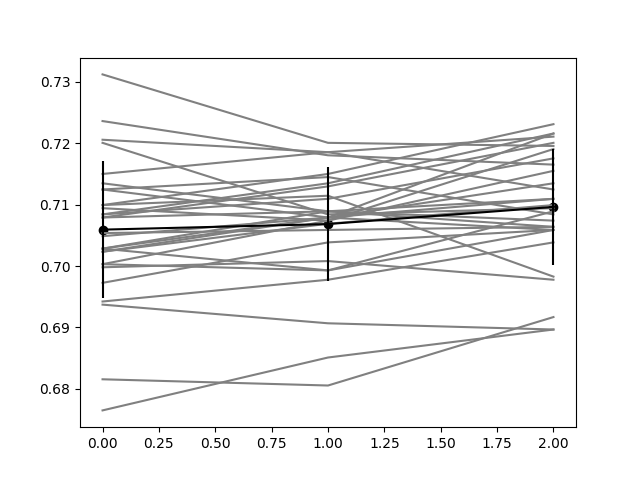

In [83]:
# 4d. Plot the accuracy across each cross-validation run to see which is the best model,
# connecting the corresponding cross-val runs with lines

acc = np.array(acc_noreg)
acc_mean = np.mean(acc,axis=1)
acc_std = np.std(acc,axis=1,ddof=1)
plt.figure()
for i in range(np.size(acc,axis=1)):
    plt.plot(np.arange(3),acc[:,i],c='grey')
plt.scatter(np.arange(3),acc_mean,c='k')
plt.errorbar(np.arange(3),acc_mean,acc_std,c='k')

<ErrorbarContainer object of 3 artists>

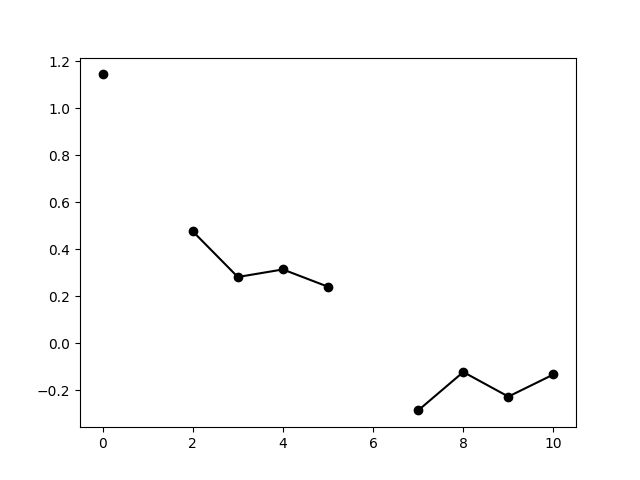

In [92]:
# 4e. Plot weights of best model (average and std across cross-validation runs)
#my best run was in the first models
max_idx = np.argmax(acc_noreg[2])
coeffs   = coef_noreg[2][max_idx]
coeffs_m = np.mean(coeffs,axis=0)
coeffs_s = np.std(coeffs,axis=0,ddof=1)
num_hist=4
plt.figure()
plt.scatter(0,coeffs_m[0],c='k')
plt.errorbar(0,coeffs_m[0],coeffs_s[0],c='k')
thisx = np.arange(1,1+num_hist)
plt.scatter(thisx+1,coeffs_m[thisx],c='k')
plt.errorbar(thisx+1,coeffs_m[thisx],coeffs_s[thisx],c='k')
thisx = np.arange(1+num_hist,len(coeffs_s))
plt.scatter(thisx+2,coeffs_m[thisx],c='k')
plt.errorbar(thisx+2,coeffs_m[thisx],coeffs_s[thisx],c='k')

In [ ]:
# 4e. Which feature is most predictive of performance? What do the signs of the weights mean?
# delta towers, positive means that those features predict an output of the same sign (negative is predict output of the opposite sign)




In [97]:
# 4f. For the best model only, refit with L1 regularization, and print the average weights.
model_l1 = LogisticRegression(penalty='l1',max_iter=500,solver='saga')
fits_l1  = [[],[],[]]
acc_l1   = [[],[],[]]
coef_l1  = [[],[],[]]

iModel = 2
print(f"Model {iModel}...")
for iXval, (train_index, test_index) in enumerate(kf.split(Xlist[iModel])):
        temp_x = Xlist[iModel]
        train_x = temp_x[train_index,:]
        train_y = y_mask[train_index]

        
        test_x = temp_x[test_index,:]
        test_y = y_mask[test_index]
        model_l1.fit(train_x, train_y)
        fits_l1[iModel].append(model_l1.score(train_x, train_y))
        #print(fits_noreg[iModel][-1])
        acc_l1[iModel].append(model_l1.score(test_x, test_y))
        #print(acc_noreg[iModel][-1])
        coef_l1[iModel].append(model_l1.coef_)
    # fill in (it will be basically the same as 4c)

# compare average coefficients with and without regularization
coef_noregs_avg = np.mean(coef_noreg[2])
coef_regs_avg = np.mean(coef_l1[2])

print(f'no_reg_:{coef_noregs_avg}')
print(f'no_reg_:{coef_regs_avg}')


Model 2...
no_reg_:0.18713680282679657
no_reg_:0.1870810625659884


In [98]:
# 4f. What are the differences in the weights, if any? What does that say about the data?
# (answer in a comment)
#almost no difference in weights, it suggests that the history predictors are "useful," and can't be simply replaced by using delta towers more


## Bonus problem: Mixed-effects models ##

**This is for the aficionados and will not be graded** <br>
The dataset above has the classic clustered design in neuroscience: data is being combined across mice, and for each mice across sessions. <br>
Fit a mixed-effects logistic regression model using random intercepts for mice (column **subject_fullname**) and sessions (column **session_date**)

In [ ]:
# The pymer4 package is great for this: https://eshinjolly.com/pymer4/
# If I recall correctly, it needs to have R installed

from   pymer4.models import Lmer